# Testing GPT-2 fine-tuned on SST-2

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from datasets import load_dataset
import numpy as np
import evaluate
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import time

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained("michelecafagna26/gpt2-medium-finetuned-sst2-sentiment")
tokenizer.pad_token = tokenizer.eos_token

In [3]:
dataset_test = load_dataset("csv", data_files="books_test.csv")

In [4]:
device = torch.device('cuda')

In [5]:
model = GPT2ForSequenceClassification.from_pretrained("michelecafagna26/gpt2-medium-finetuned-sst2-sentiment").to(device)
model.config.pad_token_id = model.config.eos_token_id


In [6]:
logits_list = []
data = dataset_test['train']['body']
batch_size = 2

for start in range(0, len(data), batch_size):
    print("Processing " + str(start))
    batch = data[start:start + batch_size]
    # tokenize all first?
    inputs = tokenizer(batch, truncation=True, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        logits_list.append(model(**inputs).logits)
logits = torch.cat(logits_list)


Processing 0
Processing 2
Processing 4
Processing 6
Processing 8
Processing 10
Processing 12
Processing 14
Processing 16
Processing 18
Processing 20
Processing 22
Processing 24
Processing 26
Processing 28
Processing 30
Processing 32
Processing 34
Processing 36
Processing 38
Processing 40
Processing 42
Processing 44
Processing 46
Processing 48
Processing 50
Processing 52
Processing 54
Processing 56
Processing 58
Processing 60
Processing 62
Processing 64
Processing 66
Processing 68
Processing 70
Processing 72
Processing 74
Processing 76
Processing 78
Processing 80
Processing 82
Processing 84
Processing 86
Processing 88
Processing 90
Processing 92
Processing 94
Processing 96
Processing 98


## Calculating accuracy, precision, F1-score

In [1]:
load_precision = evaluate.load("precision")
load_f1 = evaluate.load("f1")
load_accuracy = evaluate.load("accuracy")
labels = dataset_test['train']['label']
predictions = np.argmax(logits.data.cpu().numpy(), axis=-1)
precision = load_precision.compute(predictions=predictions, references=labels)
accuracy = load_accuracy.compute(predictions=predictions, references=labels)
f1 = load_f1.compute(predictions=predictions, references=labels)
metrics = {"accuracy": accuracy, "f1": f1, "precision": precision}

NameError: name 'evaluate' is not defined

In [21]:
print(metrics)

{'accuracy': {'accuracy': 0.78}, 'f1': {'f1': 0.8333333333333334}, 'precision': {'precision': 0.9166666666666666}}


### The accuracy is 0.78, F1-score is 0.8333333333333334, precision is 0.92

In [10]:
#logits of the inference on the testing data
sst_gpt_logits = logits.cpu().numpy()

## PR curve: calculating precision and recall 

In [11]:
y_true = np.array(dataset_test["train"]["label"])
sst_gpt_precision = []
sst_gpt_recall = []
sst_gpt_probabilities = softmax(sst_gpt_logits, axis=1)
threshold = list(np.arange(0.0, 1, 0.001))
for t in threshold:
    y_scores = (sst_gpt_probabilities[:, 1] > t).astype(int)
    sst_gpt_precision.append(precision_score(y_true, y_scores, zero_division=1))
    sst_gpt_recall.append(recall_score(y_true, y_scores, zero_division=1))

sst_gpt_precision.append(1)
sst_gpt_recall.append(0)

## Baseline model which always returns the most frequent class


In [12]:
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

## Plotting the PR curve

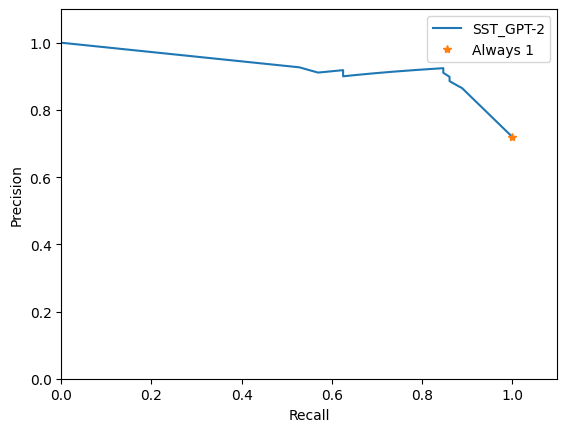

In [13]:
fig, ax = plt.subplots()
ax.plot(sst_gpt_recall, sst_gpt_precision, '-', label='SST_GPT-2')
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))
ax.legend()

In [14]:
np.savetxt("sst_gpt_logits.csv", sst_gpt_logits, delimiter = ",")

## Estimating inference time

In [18]:
model_cpu = model.to("cpu")
time_start = time.perf_counter()

for text in dataset_test["train"]["body"]:
        request = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cpu')
        outputs = model_cpu(**request)

time_end = time.perf_counter()
    
print(f'Took {(time_end - time_start):.3f} seconds')

Took 58.959 seconds
